# 0. Imports y funciones útiles

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas

# 1. Análisis exploratorio

Por agilizar el ejemplo se usa airbnb-listings-extract en vez del full. Lo primero que vamos a hacer es dividir el dataset en training y test, metiéndole ``shuffle`` y ``random_state`` como siempre. Guardamos los resultados en dos ficheros csv para que sea más manejable.

In [2]:
from sklearn.model_selection import train_test_split

full_df = pd.read_csv('./airbnb-listings-extract.csv', sep=';', decimal='.')

full_df = full_df[0:2000]

train, test = train_test_split(full_df, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

Dimensiones del dataset de training: (1600, 89)
Dimensiones del dataset de test: (400, 89)


A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 

In [3]:
df = pd.read_csv('./train.csv', sep=';', decimal='.')

Se usa head traspuesto para ver de qué va cada columna:

In [4]:
df.head().T

0  \
ID                                                                        7575022   
Listing Url                                  https://www.airbnb.com/rooms/7575022   
Scrape ID                                                          20170407214050   
Last Scraped                                                           2017-04-08   
Name                                            Barcelona center Tropic apartment   
Summary                         Luxury apartment in the very heart of the city...   
Space                           The space is in one of the typical buildings o...   
Description                     Luxury apartment in the very heart of the city...   
Experiences Offered                                                          none   
Neighborhood Overview                                                         NaN   
Notes                           There are 3 stops of different train lines in ...   
Transit                                                                       NaN   
Access                          We accept all type of guests, but being respec...   
Interaction                     This part of l'eixample is the heart of Barcel...   
House Rules                                                                   NaN   
Thumbnail Url                   https://a0.muscache.com/im/pictures/c4a95d1c-f...   
Medium Url                      https://a0.muscache.com/im/pictures/c4a95d1c-f...   
Picture Url                     https://public.opendatasoft.com/api/v2/catalog...   
XL Picture Url                  https://a0.muscache.com/im/pictures/c4a95d1c-f...   
Host ID                                                                   5610456   
Host URL                                https://www.airbnb.com/users/show/5610456   
Host Name                                                                  Marcos   
Host Since                                                             2013-03-24   
Host Location                                  Madrid, Community of Madrid, Spain   
Host About                               Clean and respectful and I love animals.   
Host Response Time                                                 within an hour   
Host Response Rate                                                             95   
Host Acceptance Rate                                                          NaN   
Host Thumbnail Url              https://a0.muscache.com/im/pictures/77e9ba74-c...   
Host Picture Url                https://a0.muscache.com/im/pictures/77e9ba74-c...   
Host Neighbourhood                                            Dreta de l'Eixample   
Host Listings Count                                                             3   
Host Total Listings Count                                                       3   
Host Verifications                             email,phone,facebook,reviews,jumio   
Street                          Dreta de l'Eixample, Barcelona, Catalunya 0800...   
Neighbourhood                                                 Dreta de l'Eixample   
Neighbourhood Cleansed                                     la Dreta de l'Eixample   
Neighbourhood Group Cleansed                                             Eixample   
City                                                                    Barcelona   
State                                                                   Catalunya   
Zipcode                                                                     08008   
Market                                                                  Barcelona   
Smart Location                                                   Barcelona, Spain   
Country Code                                                                   ES   
Country                                                                     Spain   
Latitude                                                                  41.3945   
Longitude                                                                 2.15904   


Se ve que gran parte de los datos no aportan información relevante. Se van a eliminar de inmediato las columnas:

- Listing Url
- Scrape ID: no aporta información sobre la propiedad.
- Last Scraped: no aporta información sobre la propiedad.
- Thumbnail Url
- Medium Url
- Picture Url
- XL Picture Url
- Host ID: aporta información sobre el dueño, pero no sobre la propiedad (podría revisarse su inclusión si los resultados no son buenos).
- Host Url
- Host Name: no aporta información sobre la propiedad. Podría ser de interés estadístico otro tipo de dato categórico del dueño (rango de edad, sexo...) pero no el nombre.
- Host Thumbnail Url
- Host Picture Url
- Host Neighbourhood: no aporta información sobre la propiedad.
- Weekly Price: información redundante que puede actuar como predictor (y no debe)
- Monthly Price: información redundante que puede actuar como predictor (y no debe)
- Calendar Updated: información irrelevante; se podría inferir la frecuencia de actividad del dueño, pero YA hay un dato explícito de su tasa de respuesta.
- Calendar last Scraped: no aporta información sobre la propiedad.
- First review: no aporta información nueva; ya hay un dato de antiguedad del dueño.
- Last review: no aporta información nueva.
- Reviews per Month: no aporta información nueva
- Geolocation: es latitud + longitud
- Host Listings Count, Host Total Listings Count, Calculated host listings count: contador relacionado con el dueño; no aporta información sobre la propiedad.


In [5]:
# Hacemos un drop de todas las columnas que OBVIAMENTE no aportan información relevante
not_useful_columns = [
    'ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Medium Url', 
    'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name', 
    'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood', 'Weekly Price', 
    'Monthly Price', 'Calendar Updated', 'Calendar last Scraped', 'First Review', 
    'Last Review', 'Reviews per Month', 'Geolocation', 'Calculated host listings count',
    'Host Listings Count', 'Host Total Listings Count'
]

df.drop(not_useful_columns, axis=1, inplace=True)

Y luego hay una serie de columnas que, si bien aportan mucha información, exigen un tratamiento previo que queda fuera del alcance de este trabajo. Name, summary, description... exigirían tokenización y un análisis con NLP para poder sacar algo en claro, de modo que se eliminan. En un entorno real, probablemente tendréis que realizar ese análisis :) y si alguien lo ha hecho, lo tendré muy en cuenta!

In [6]:
# Hacemos un drop de todas las columnas que aportando información quedan fuera del scope
somehow_useful_columns_but_droppable_anyway = ['Name', 'Summary', 'Space', 'Description',
       'Neighborhood Overview', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Host Location', 'Host About'
]

df.drop(somehow_useful_columns_but_droppable_anyway, axis=1, inplace=True)

Se analiza el número de valores diferentes por columnas.

In [7]:
df.apply(lambda x: len(x.unique()))

Experiences Offered                3
Thumbnail Url                   1347
Host Since                       934
Host Response Time                 5
Host Response Rate                49
Host Acceptance Rate               4
Host Verifications                99
Street                           489
Neighbourhood                    138
Neighbourhood Cleansed           214
Neighbourhood Group Cleansed      34
City                              56
State                             36
Zipcode                          179
Market                            22
Smart Location                    58
Country Code                      12
Country                           12
Latitude                        1600
Longitude                       1600
Property Type                     15
Room Type                          3
Accommodates                      14
Bathrooms                         15
Bedrooms                          11
Beds                              14
Bed Type                           4
A

La variable Street no muestra realmente la calle; en muchas, simplemente es la ciudad y un código postal (variables que ya tienen su propia columna). Es una variable muy ruidosa y no categorizada.

Por otro lado, City, State, Market y Smart Location aportan la misma información, al igual que Country y Country Code y de forma similar a Neighbourhood y Zipcode. Este paso es controvertido; es aventurado eliminar sin más estas columnas. Sin embargo, es válido para una primera aproximación. Nos quedamos con City y eliminamos las demás.

**Nota**: en este caso concreto, con esta selección de listings, la inmensísima mayoría de registros son madrileños. En la exploración de los datos esto se ve claro, y otra posibilidad sería eliminar todo aquello no madrileño y predecir solo con los datos de Madrid. Pero ¿qué pasa luego? Pues depende de qué estemos haciendo, depende del contexto de negocio/investigación. A la hora de explicar los resultados habría que indicar que son referentes a los datos de Madrid y que no es válida una extrapolación directa a Los Angeles, por ejemplo... habría que decidir en función de si es válido un análisis ciudad a ciudad o si se pretende una predicción global.

In [8]:
df.drop(['Street', 'State', 'Market', 'Smart Location', 'Country', 'Zipcode'], axis=1, inplace=True)

Por último se comprueba qué variables tienen muchos valores missing (NaN or null). Hay columnas en las que apenas hay datos. De un total de unos 12000 registros, columnas como Host Acceptance Rate o Square Feet tienen más de 11000 vacíos. No es conveniente imputar valores, ya que no hay una muestra significativa para extraer medias. Se hace drop de las columnas con muchos valores NaN.

In [9]:
print(f'El dataframe tiene un total de {len(df)} filas.')
len(df) - df.count() # vemos cuántos valores NaN hay por columna

# df.isnull().any() # vemos qué columnas tienen valores NaN

El dataframe tiene un total de 1600 filas.


Experiences Offered                0
Thumbnail Url                    254
Host Since                         0
Host Response Time               195
Host Response Rate               195
Host Acceptance Rate            1597
Host Verifications                 1
Neighbourhood                    524
Neighbourhood Cleansed             0
Neighbourhood Group Cleansed      98
City                               0
Country Code                       0
Latitude                           0
Longitude                          0
Property Type                      0
Room Type                          0
Accommodates                       0
Bathrooms                          8
Bedrooms                           3
Beds                               5
Bed Type                           0
Amenities                         23
Square Feet                     1529
Price                              2
Security Deposit                 942
Cleaning Fee                     651
Guests Included                    0
E

In [10]:
columns_with_too_many_missing_values = [
    'Host Acceptance Rate', 'Square Feet', 'Has Availability', 'License', 'Jurisdiction Names'
]

df.drop(columns_with_too_many_missing_values, axis=1, inplace=True)

## 1.1 Variables redundantes

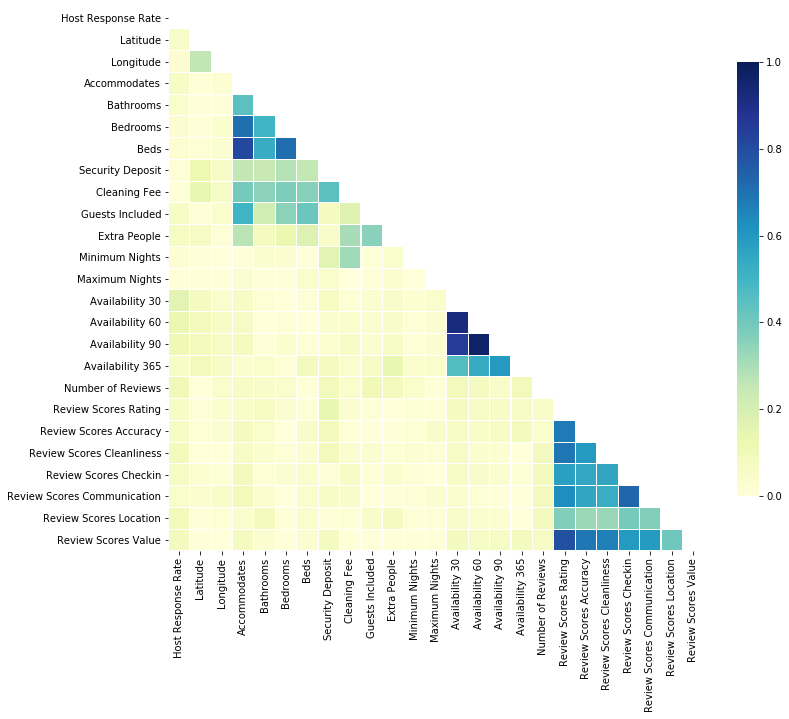

In [11]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df.drop(['Price'], axis=1).corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

# puedo representar solo la parte inferior ya que es simétrica

Vemos que hay mucha correlación entre las variables de availability y las de reviews. Podemos eliminar todas las availability salvo 365 y hacer una media de las de review; he decidido hacer media porque son reviews, pero podría escogerse otra estrategia, o incluso conservarlas todas ya que técnicamente no hacen referencia a la misma info. Eliminamos también Accommodates que tiene correlación alta con Beds.

In [12]:
reviews = df.loc[: , "Review Scores Rating":"Review Scores Value"]
df['Average Review'] = reviews.mean(axis=1)

df.drop(['Availability 30', 'Availability 60', 'Availability 90', 'Review Scores Rating', 
         'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location', 'Review Scores Value',
        'Accommodates'], axis=1, inplace=True)

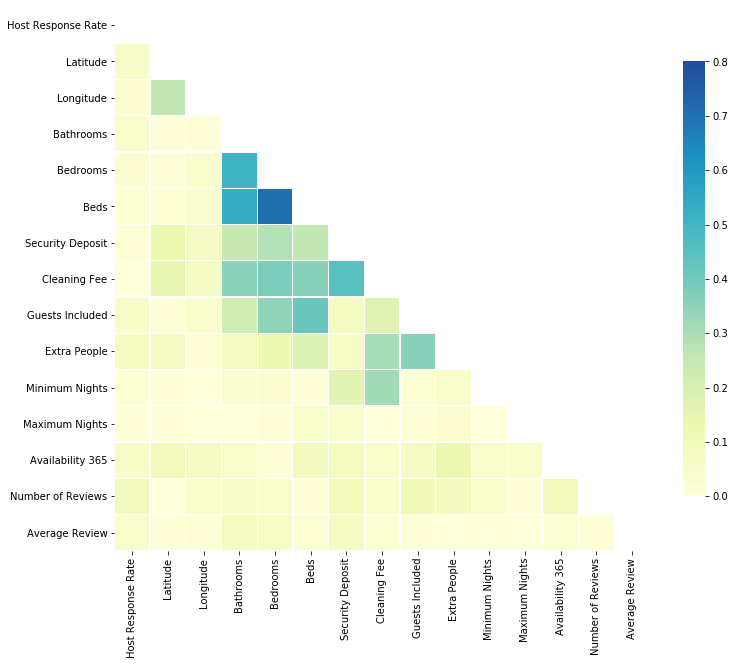

In [13]:
# Compute the correlation matrix
corr = np.abs(df.drop(['Price'], axis=1).corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=0.8, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

# La matriz de correlación tiene mejor pinta

Por último, podemos hacer una representación (scatter_plot) de todas las variables frente al resto, para tener una idea de cómo se relacionan las variables del problema.

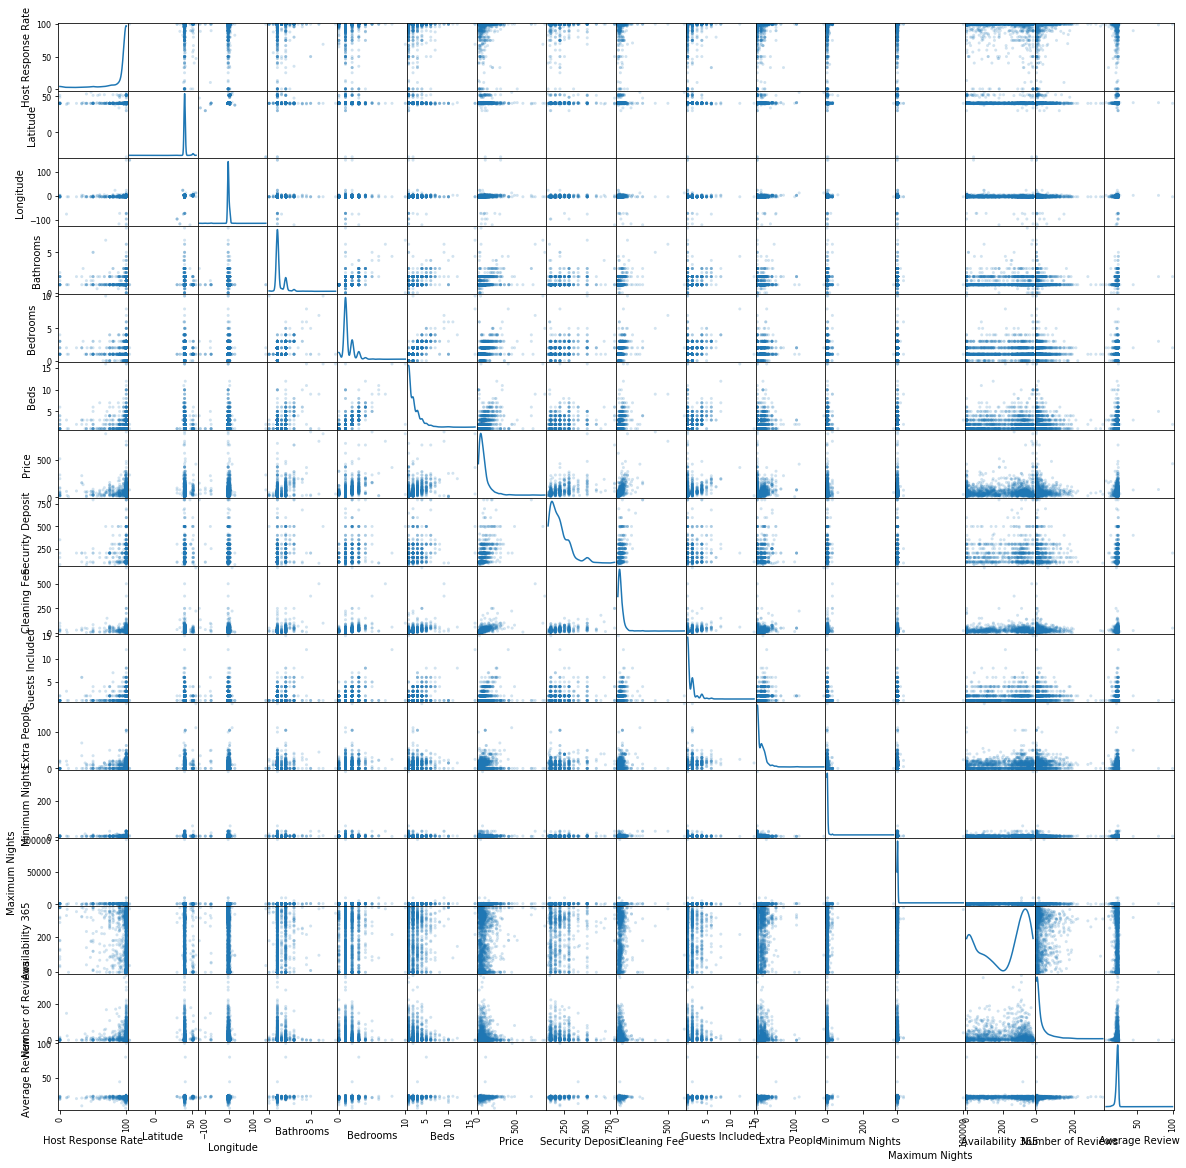

In [14]:
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal = 'kde')
plt.show()

Por último, vamos a eliminar outliers en la variable Price usando un filtro.

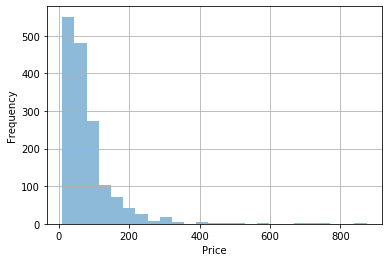

In [15]:
df['Price'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Price')

plt.show()

In [16]:
len(df[df['Price'] > 200]) # tan solo estos valores (de 12k!) son mayores de 200. Es un filtro válido.
# Haced la prueba, con > 100 saldrán en torno a 2k valores, que es un corte mucho mayor.

84

In [17]:
# Cuidado, que esto también elimina los nulos! En este caso no importa, pero hay que revisar si el filtro
# se carga muchos valores

df = df[df['Price'] < 200]

Tras el primer análisis se ha bajado de las 89 columnas iniciales a:

In [18]:
df.shape

(1501, 32)

In [19]:
df.describe().T

count        mean          std         min         25%  \
Host Response Rate  1321.0   94.796366    15.279126    0.000000   99.000000   
Latitude            1501.0   40.857446     2.904726  -33.870194   40.410987   
Longitude           1501.0   -3.179566     9.413107 -122.355344   -3.707107   
Bathrooms           1493.0    1.215003     0.518740    0.000000    1.000000   
Bedrooms            1498.0    1.297730     0.792926    0.000000    1.000000   
Beds                1496.0    1.911096     1.334185    1.000000    1.000000   
Price               1501.0   64.945370    40.775217   10.000000   32.000000   
Security Deposit     608.0  187.855263   112.880054   70.000000  100.000000   
Cleaning Fee         891.0   29.393939    22.868032    5.000000   15.000000   
Guests Included     1501.0    1.535643     0.996441    1.000000    1.000000   
Extra People        1501.0    8.071286    11.450629    0.000000    0.000000   
Minimum Nights      1501.0    2.966689    10.126280    1.000000    1.000000   
Maximum Nights      1501.0  900.281812  2628.447990    1.000000  200.000000   
Availability 365    1501.0  192.163225   130.519830    0.000000   66.000000   
Number of Reviews   1501.0   22.716855    38.884638    0.000000    1.000000   
Average Review      1166.0   21.225598     2.546669    8.857143   20.571429   

                            50%          75%           max  
Host Response Rate   100.000000   100.000000    100.000000  
Latitude              40.422768    40.450781     55.943928  
Longitude             -3.699716    -3.666411    151.218576  
Bathrooms              1.000000     1.000000      8.000000  
Bedrooms               1.000000     2.000000     10.000000  
Beds                   1.000000     2.000000     16.000000  
Price                 55.000000    87.000000    199.000000  
Security Deposit     150.000000   200.000000    800.000000  
Cleaning Fee          25.000000    36.000000    250.000000  
Guests Included        1.000000     2.000000     15.000000  
Extra People           0.000000    15.000000    105.000000  
Minimum Nights         2.000000     3.000000    365.000000  
Maximum Nights      1125.000000  1125.000000  99999.000000  
Availability 365     215.000000   314.000000    365.000000  
Number of Reviews      7.000000    27.000000    356.000000  
Average Review        21.571429    22.428571     80.000000

# 2. Generación de características

Parece curioso que haya tres variables diferentes con información sobre el vecindario; a ver qué pasa si se muestran más filas:

In [20]:
df_n = df[['Neighbourhood', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed']]
df_n.head(20)

Neighbourhood  Neighbourhood Cleansed Neighbourhood Group Cleansed
0   Dreta de l'Eixample  la Dreta de l'Eixample                     Eixample
1         Ciudad Lineal            Pueblo Nuevo                Ciudad Lineal
2                   NaN                   Timón                      Barajas
3             Trafalgar               Trafalgar                     Chamberí
4        Sants-Montjuïc                   Sants               Sants-Montjuïc
5              Malasaña             Universidad                       Centro
6              Justicia                Justicia                       Centro
7                   NaN                     Sol                       Centro
8                Cortes                  Cortes                       Centro
9             La Latina             Embajadores                       Centro
10      Palos do Moguer         Palos de Moguer                   Arganzuela
12            Les Corts               les Corts                    Les Corts
14             Oud-West  De Baarsjes - Oud-West                          NaN
15            La Latina             Embajadores                       Centro
16                  NaN              Castellana                    Salamanca
17            La Latina                 Palacio                       Centro
18          Embajadores             Embajadores                       Centro
19               Cortes                  Cortes                       Centro
20                 Goya                    Goya                    Salamanca
21                  Sol                     Sol                       Centro

Parece que va de más detalle a menos. Si observamos los valores únicos de cada columna se ve que cleansed no tiene valores missing:

In [21]:
print(f'El dataframe tiene un total de {len(df_n)} filas.')
len(df_n) - df_n.count() # vemos cuántos valores NaN hay por columna

El dataframe tiene un total de 1501 filas.


Neighbourhood                   480
Neighbourhood Cleansed            0
Neighbourhood Group Cleansed     81
dtype: int64

Pero a cambio tiene muchos más valores diferentes:

In [22]:
df_n.apply(lambda x: len(x.unique())) # vemos el número de valores distintos por columna

Neighbourhood                   133
Neighbourhood Cleansed          202
Neighbourhood Group Cleansed     34
dtype: int64

#### Primera creación de características

Se va a usar Neighbourhood Group Cleansed a no ser que sea NaN/Null; en ese caso se rellenará con Neighbourhood Cleansed

In [23]:
df_n["Final Neighbourhood"] = df_n["Neighbourhood Group Cleansed"].fillna(df_n["Neighbourhood Cleansed"])

In [24]:
len(df_n) - df_n.count() # Final neighbourhood no tiene valores missing

Neighbourhood                   480
Neighbourhood Cleansed            0
Neighbourhood Group Cleansed     81
Final Neighbourhood               0
dtype: int64

In [25]:
df_n.apply(lambda x: len(x.unique())) # y aunque tiene más valores diferentes que group cleansed, tiene menos que cleansed

Neighbourhood                   133
Neighbourhood Cleansed          202
Neighbourhood Group Cleansed     34
Final Neighbourhood              87
dtype: int64

Aplicamos al dataset original y eliminamos las tres columnas de neighbourhood:

In [26]:
df["Final Neighbourhood"] = df["Neighbourhood Group Cleansed"].fillna(df["Neighbourhood Cleansed"])
df.drop(["Neighbourhood", "Neighbourhood Group Cleansed", "Neighbourhood Cleansed"], axis=1, inplace=True)

#### Segunda generación de características:

Host Verifications, Features y Amenities exigirían un análisis NLP, pero hay información directa que se puede extraer. Todas son listas, separadas por comas. Se puede contar el número de elementos en cada lista y usarlo como característica.

**Nota**: Estas generaciones de características se me han ocurrido sobre la marcha y me parece que pueden tener sentido; alguien podría argumentarme en contra que si una casa tiene secador de pelo y bolsitas de té para el desayuno tendría 2 Amenities, mientras que otra con WiFi (pero sin secador ni té) tendría 1, y que por tanto es una generación incorrecta porque debería darle más peso a determinadas Amenities frente a otras. Toda la razón, no todas las Features/Amenities deberían contar igual, y se podría realizar un análisis de frecuencias para asignarles un peso, o decidir manualmente cuáles son las más importantes; recordad que esto es solo una introducción al ML! Todo lo que queráis avanzar y probar está genial, adelante.

In [27]:
df_l = df[['Features', 'Amenities', 'Host Verifications']]
df_l.fillna("", inplace=True) # rellenamos los huecos con cadenas vacías

df_l['Features'] = df_l['Features'].apply(lambda x: len(str(x).split(',')))
df_l['Amenities'] = df_l['Amenities'].apply(lambda x: len(str(x).split(',')))
df_l['Host Verifications'] = df_l['Host Verifications'].apply(lambda x: len(str(x).split(',')))

df_l.head(10)

Features  Amenities  Host Verifications
0         4         12                   5
1         4         12                   3
2         4         14                   6
3         4         21                   3
4         4         22                   5
5         5         22                   4
6         5         12                   4
7         3         12                   5
8         4         11                   4
9         5         15                   6

Aplicamos al dataset original:

In [28]:
df['Features'].fillna("", inplace=True)
df['Amenities'].fillna("", inplace=True)
df['Host Verifications'].fillna("", inplace=True)

df['Features'] = df['Features'].apply(lambda x: len(str(x).split(',')))
df['Amenities'] = df['Amenities'].apply(lambda x: len(str(x).split(',')))
df['Host Verifications'] = df['Host Verifications'].apply(lambda x: len(str(x).split(',')))

In [29]:
df.columns

Index(['Experiences Offered', 'Thumbnail Url', 'Host Since',
       'Host Response Time', 'Host Response Rate', 'Host Verifications',
       'City', 'Country Code', 'Latitude', 'Longitude', 'Property Type',
       'Room Type', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type', 'Amenities',
       'Price', 'Security Deposit', 'Cleaning Fee', 'Guests Included',
       'Extra People', 'Minimum Nights', 'Maximum Nights', 'Availability 365',
       'Number of Reviews', 'Cancellation Policy', 'Features',
       'Average Review', 'Final Neighbourhood'],
      dtype='object')

#### Tercera generación de características

Antigüedad del dueño en la plataforma

In [30]:
from datetime import datetime

df.dropna(subset=['Host Since'], inplace=True) # se ha visto antes que solo hay tres valores missing, no se pierde mucho

df['Host Since'] = df['Host Since'].apply(lambda x: datetime.strptime(str(x),'%Y-%m-%d'))
df['Years Being Host'] = df['Host Since'].apply(lambda x: 2017 - x.year)

df.drop(['Host Since'], axis=1, inplace=True)

# 3. Categorización de variables

De qué tipo son las columnas restantes? Las numéricas se convierten a float, y se va a hacer una limpieza general: cero baños, precio cero... esas cosas pueden y deben limpiarse al recoger los datos. 

In [31]:
print(f"Registros con cero baños: {len(df[df['Bathrooms'] == 0])}")
print(f"Registros con precio cero: {len(df[df['Price'] == 0])}")
      
df = df[df['Bathrooms'] != 0]
df = df[df['Price'] != 0]
df = df[df['Thumbnail Url'].notna()]

Registros con cero baños: 8
Registros con precio cero: 0


Se ve que las columnas no numéricas que quedan son:

In [32]:
list(df.select_dtypes(include=['object']).columns)

['Experiences Offered',
 'Thumbnail Url',
 'Host Response Time',
 'City',
 'Country Code',
 'Property Type',
 'Room Type',
 'Bed Type',
 'Cancellation Policy',
 'Final Neighbourhood']

In [33]:
df_nn = df[list(df.select_dtypes(include=['object']).columns)]
df_nn.apply(lambda x: len(x.unique())) # valores diferentes

Experiences Offered       2
Thumbnail Url          1265
Host Response Time        5
City                     37
Country Code             11
Property Type            14
Room Type                 3
Bed Type                  4
Cancellation Policy       5
Final Neighbourhood      78
dtype: int64

In [34]:
len(df_nn) - df_nn.count() # solo market y host response time tienen missing values

Experiences Offered      0
Thumbnail Url            0
Host Response Time     139
City                     0
Country Code             0
Property Type            0
Room Type                0
Bed Type                 0
Cancellation Policy      0
Final Neighbourhood      0
dtype: int64

In [35]:
df_nn["Host Response Time"].value_counts()

within an hour        756
within a few hours    219
within a day          127
a few days or more     24
Name: Host Response Time, dtype: int64

Como no tenemos más datos, rellenamos con la opción más frecuente, en este caso within an hour, sobre el dataset original.

In [36]:
df["Host Response Time"].fillna(df["Host Response Time"].mode()[0], inplace=True)

Y la columna experiences offered? Qué valores tiene? Parece que muy pocos, la mayoría son none. Podemos borrarla

In [37]:
df["Experiences Offered"].value_counts()

none        1264
business       1
Name: Experiences Offered, dtype: int64

In [38]:
df.drop(['Experiences Offered'], axis=1, inplace=True)

Ahora lo mismo con el resto de columnas

In [39]:
df_nn["City"].value_counts()

Madrid                             1008
Barcelona                           178
London                               19
Amsterdam                            18
Paris                                 3
Madrid, Comunidad de Madrid, ES       3
Austin                                3
Brooklyn                              2
Pozuelo de Alarcón                    2
Palma                                 2
Llucmajor                             1
Port d'Andratx                        1
Berlin                                1
Portals Nous                          1
Alcúdia                               1
Roma                                  1
Salerno                               1
Greater London                        1
Washington                            1
Pasadena                              1
New York                              1
Madri                                 1
Port de Pollença                      1
Hospitalet de Llobregat               1
Antwerpen                             1


In [40]:
df_nn["Country Code"].value_counts()

ES    1202
GB      23
NL      18
US      10
FR       3
BE       3
GR       2
AU       1
DE       1
IT       1
It       1
Name: Country Code, dtype: int64

En este caso es arriesgado (e incorrecto) rellenar con la moda. Una posibilidad es tratar de inferir el valor correcto de City, muy ruidoso, en función de Market y Street (probadlo si queréis!); otra, simplemente eliminar los 6 registros que no tienen definida la variable. Pero realmente, a estas alturas, lo mejor es simplemente eliminarla, ya que la amplísima mayoría de valores son exactamente iguales: Madrid.

Lo mismo con Country Code.

In [41]:
df.drop(['City', 'Country Code'], axis=1, inplace=True)

Ahora podemos aplicar un encoder sobre las variables categóricas. Aplicamos un smoother extraído [del tutorial de Max Halford](https://maxhalford.github.io/blog/target-encoding-done-the-right-way/), uno de los ejemplos que os puse en Slack. Tened en cuenta que si existieran valores en test no vistos en train, habría que tenerlo en cuenta (quizá creando una categoría "Unknown")

In [42]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import os

In [43]:
categorical = ['Host Response Time', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy',
 'Final Neighbourhood'
]

# Creamos un dict para usarlo después en test
mean_map = {}
for c in categorical:
    mean = df.groupby(c)['Price'].mean()
    df[c] = df[c].map(mean)    
    mean_map[c] = mean

In [44]:
mean_map

{'Host Response Time': Host Response Time
 a few days or more    63.833333
 within a day          55.535433
 within a few hours    54.616438
 within an hour        65.477095
 Name: Price, dtype: float64,
 'Property Type': Property Type
 Apartment              64.117590
 Bed & Breakfast        34.975610
 Boat                  102.000000
 Camper/RV             125.000000
 Chalet                 40.000000
 Condominium            67.909091
 Dorm                   40.000000
 Guesthouse             65.000000
 Hostel                 45.000000
 House                  53.936842
 Loft                   67.923077
 Other                  61.576923
 Serviced apartment     61.000000
 Townhouse              68.500000
 Name: Price, dtype: float64,
 'Room Type': Room Type
 Entire home/apt    83.924554
 Private room       33.875479
 Shared room        20.285714
 Name: Price, dtype: float64,
 'Bed Type': Bed Type
 Couch            45.000000
 Futon            28.750000
 Pull-out Sofa    43.214286
 Real Be

Por último, rellenamos los valores NaNs con la media de las columnas numéricas

In [45]:
# Esto solo sirve para mover price a la primera posición
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('Price')))
df = df[cols]

df.fillna(df.mean(), inplace=True)
df.isnull().any()

Price                  False
Thumbnail Url          False
Host Response Time     False
Host Response Rate     False
Host Verifications     False
Latitude               False
Longitude              False
Property Type          False
Room Type              False
Bathrooms              False
Bedrooms               False
Beds                   False
Bed Type               False
Amenities              False
Security Deposit       False
Cleaning Fee           False
Guests Included        False
Extra People           False
Minimum Nights         False
Maximum Nights         False
Availability 365       False
Number of Reviews      False
Cancellation Policy    False
Features               False
Average Review         False
Final Neighbourhood    False
Years Being Host       False
dtype: bool

In [46]:
df.describe()

Price  Host Response Time  Host Response Rate  \
count  1265.000000         1265.000000         1265.000000   
mean     62.567589           62.567589           95.523979   
std      39.722599            4.684718           12.899283   
min      10.000000           54.616438            0.000000   
25%      30.000000           55.535433           95.523979   
50%      51.000000           65.477095          100.000000   
75%      85.000000           65.477095          100.000000   
max     199.000000           65.477095          100.000000   

       Host Verifications     Latitude    Longitude  Property Type  \
count         1265.000000  1265.000000  1265.000000    1265.000000   
mean             4.174704    40.893064    -3.141887      62.567589   
std              1.291523     3.097241     9.789695       6.522459   
min              1.000000   -33.870194  -122.355344      34.975610   
25%              3.000000    40.410916    -3.707535      64.117590   
50%              4.000000    40.423278    -3.699304      64.117590   
75%              5.000000    40.454981    -3.662465      64.117590   
max              9.000000    55.943928   151.218576     125.000000   

         Room Type    Bathrooms     Bedrooms         Beds     Bed Type  \
count  1265.000000  1265.000000  1265.000000  1265.000000  1265.000000   
mean     62.567589     1.212470     1.276545     1.880349    62.567589   
std      24.956764     0.508172     0.727231     1.318362     2.894769   
min      20.285714     0.500000     0.000000     1.000000    28.750000   
25%      33.875479     1.000000     1.000000     1.000000    62.922088   
50%      83.924554     1.000000     1.000000     1.000000    62.922088   
75%      83.924554     1.000000     2.000000     2.000000    62.922088   
max      83.924554     8.000000     6.000000    16.000000    62.922088   

         Amenities  Security Deposit  Cleaning Fee  Guests Included  \
count  1265.000000       1265.000000   1265.000000      1265.000000   
mean     14.051383        187.261386     28.410596         1.520158   
std       5.021446         71.869814     16.031484         0.975870   
min       1.000000         70.000000      5.000000         1.000000   
25%      10.000000        187.261386     20.000000         1.000000   
50%      14.000000        187.261386     28.410596         1.000000   
75%      17.000000        187.261386     30.000000         2.000000   
max      39.000000        800.000000    250.000000        15.000000   

       Extra People  Minimum Nights  Maximum Nights  Availability 365  \
count   1265.000000     1265.000000     1265.000000       1265.000000   
mean       8.033202        2.367589      902.686957        188.889328   
std       11.409267        2.221883     2844.757447        130.288004   
min        0.000000        1.000000        1.000000          0.000000   
25%        0.000000        1.000000      180.000000         64.000000   
50%        0.000000        2.000000     1125.000000        207.000000   
75%       15.000000        3.000000     1125.000000        313.000000   
max      105.000000       26.000000    99999.000000        365.000000   

       Number of Reviews  Cancellation Policy     Features  Average Review  \
count        1265.000000          1265.000000  1265.000000     1265.000000   
mean           24.923320            62.567589     3.796047       21.291350   
std            41.047167             8.105321     1.035517        2.304753   
min             0.000000            53.735577     1.000000        8.857143   
25%             1.000000            53.735577     3.000000       21.000000   
50%             8.000000            60.516216     4.000000       21.291350   
75%            31.000000            71.154506     5.000000       22.142857   
max           356.000000            97.250000     7.000000       80.000000   

       Final Neighbourhood  Years Being Host  
count          1265.000000       1265.000000  
mean             62.567589          2.681423  
std           

### Separo las imágenes de las datos categóricos y numéricos

### Convierto las imágenes a vectores

In [47]:
# import the necessary packages
import pandas as pd
import numpy as np
import glob
import cv2
import os
import requests
from skimage import io

from tqdm import tqdm

In [66]:
from keras.optimizers import Adam
from keras.layers import concatenate
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing import image
#from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
#from keras.utils.vis_utils import model_to_dot
#from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model


In [49]:
def convert_images(df):
    images = []
    correct_url = 0
    wrong_url = 0
    for ix,url in enumerate(df["Thumbnail Url"].values):
        try:
            print(f"Downloading {ix}:{url} ...")
            image = io.imread(url)
            cv2.imshow("Correct", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            image = cv2.resize(image, (64, 64))
            images.append(image)
            correct_url +=1
        except Exception as e:
            print(f"Drop row {ix}. {url} denied.")
            print(f" Error type: {e}")
            df = df.drop(df.index[ix])
            wrong_url +=1
    
    print(f"Correct url of the dataframe:{correct_url}")
    print(f"Wrong url of the dataframe:{wrong_url}")
    
    images = np.array(images)/255
    
    return df, images

In [50]:
df, array_train_images = convert_images(df) #Numpy arrray that represent the images of the dataframe

Drop row 478. https://a0.muscache.com/im/pictures/066dc53b-ca61-4010-8b09-e1444e186f29.jpg?aki_policy=small denied.
 Error type: HTTP Error 404: Not Found


Correct url of the dataframe:1264
Wrong url of the dataframe:1


In [51]:
df.drop(columns=['Thumbnail Url'], axis=1, inplace=True)

# 4 Construcción y validación del modelo

In [52]:
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')

not_useful_columns = [
    'ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Medium Url', 
    'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name', 
    'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood', 'Weekly Price', 
    'Monthly Price', 'Calendar Updated', 'Calendar last Scraped', 'First Review', 
    'Last Review', 'Reviews per Month', 'Geolocation', 'Calculated host listings count',
    'Host Listings Count', 'Host Total Listings Count'
]
somehow_useful_columns_but_droppable_anyway = ['Name', 'Summary', 'Space', 'Description',
       'Neighborhood Overview', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Host Location', 'Host About'
]
columns_with_too_many_missing_values = [
    'Host Acceptance Rate', 'Square Feet', 'Has Availability', 'License', 'Jurisdiction Names'
]

df_test.drop(not_useful_columns, axis=1, inplace=True)
df_test.drop(somehow_useful_columns_but_droppable_anyway, axis=1, inplace=True)
df_test.drop(['Street', 'State', 'Market', 'Smart Location', 'Country', 'Zipcode'], axis=1, inplace=True)
df_test.drop(columns_with_too_many_missing_values, axis=1, inplace=True)

reviews = df_test.loc[: , "Review Scores Rating":"Review Scores Value"]
df_test['Average Review'] = reviews.mean(axis=1)

df_test.drop(['Availability 30', 'Availability 60', 'Availability 90', 'Review Scores Rating', 
         'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location', 'Review Scores Value',
        'Accommodates'], axis=1, inplace=True)

df_test = df_test[df_test['Price'] < 200]

df_test["Final Neighbourhood"] = df_test["Neighbourhood Group Cleansed"].fillna(df_test["Neighbourhood Cleansed"])
df_test.drop(["Neighbourhood", "Neighbourhood Group Cleansed", "Neighbourhood Cleansed"], axis=1, inplace=True)

df_test['Features'].fillna("", inplace=True) # rellenamos los huecos con cadenas vacías
df_test['Amenities'].fillna("", inplace=True)
df_test['Host Verifications'].fillna("", inplace=True)

df_test['Features'] = df_test['Features'].apply(lambda x: len(str(x).split(',')))
df_test['Amenities'] = df_test['Amenities'].apply(lambda x: len(str(x).split(',')))
df_test['Host Verifications'] = df_test['Host Verifications'].apply(lambda x: len(str(x).split(',')))

df_test.dropna(subset=['Host Since'], inplace=True)
df_test['Host Since'] = df_test['Host Since'].apply(lambda x: datetime.strptime(str(x),'%Y-%m-%d'))
df_test['Years Being Host'] = df_test['Host Since'].apply(lambda x: 2017 - x.year)
df_test.drop(['Host Since'], axis=1, inplace=True)

df_test = df_test[df_test['Bathrooms'] != 0]
df_test = df_test[df_test['Price'] != 0]
df_test = df_test[df_test['Thumbnail Url'].notna()]

result_test = convert_images(df_test)
df_test = result_test[0]
array_test_images = result_test[1]

df_test.drop(columns=['Thumbnail Url'],axis=1, inplace=True)

df_test["Host Response Time"].fillna(df["Host Response Time"].mode()[0], inplace=True)
df_test.drop(['Experiences Offered'], axis=1, inplace=True)
df_test.drop(['City', 'Country Code'], axis=1, inplace=True)


categorical = ['Host Response Time', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy',
 'Final Neighbourhood']

# Categorizamos con los datos de train!
for c in categorical:
    df_test[c] = df_test[c].map(mean_map[c])

# Comprobamos que no quedan valores no numéricos
df[categorical].dtypes

Correct url of the dataframe:291
Wrong url of the dataframe:0


Host Response Time     float64
Property Type          float64
Room Type              float64
Bed Type               float64
Cancellation Policy    float64
Final Neighbourhood    float64
dtype: object

In [53]:
cols = df_test.columns.tolist()
cols.insert(0, cols.pop(cols.index('Price')))
df_test = df_test[cols]

df_test.fillna(df.mean(), inplace=True)

print(df.shape, df_test.shape)

(1264, 26) (291, 26)


In [54]:
continuous = list(df.columns)
continuous = continuous[1:]

In [55]:
X_train = df[continuous]
y_train = df["Price"]

X_test = df_test[continuous]
y_test = df_test["Price"]

In [56]:
from sklearn.preprocessing import MinMaxScaler

cs = MinMaxScaler()
X_train = cs.fit_transform(X_train[continuous])
X_test = cs.transform(X_test[continuous])

In [57]:
maxPrice = y_train.max()
y_train = y_train / maxPrice
y_test= y_test / maxPrice

In [58]:
array_train_images.shape

(1264, 64, 64, 3)

# Keras

### Fully-connected network. Numerical and categorical data

In [59]:
def create_mlp(dim, regress=False):
    
    # define our MLP network
    model = Sequential()
    model.add(Dense(32, input_dim=dim, activation="relu"))
    model.add(Dense(16, input_dim=dim, activation="relu"))
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))
    
    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
    
    # return our model
    return model

### Convuntional network. Images.

In [60]:
# import the necessary packages
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Dense, Flatten, Input


def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)
    # loop over the number of filters
    for (i, f) in enumerate(filters):
    # if this is the first CONV layer then set the input appropriately
        if i == 0:
            x = inputs
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)
    # apply another FC layer, this one to match the number of nodes coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)
    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)
    # construct the CNN
    model = Model(inputs, x)
    # return the CNN
    return model

In [64]:
mlp = create_mlp(X_train.shape[1], regress=True)
cnn = create_cnn(64, 64, 3, regress=True)

# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(1, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

In [68]:
# compile the model using mean absolute percentage error as our loss,
# implying that we seek to minimize the absolute percentage difference
# between our price *predictions* and the *actual prices*
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
# train the model
print("[INFO] training model...")
model.fit(
    x=[X_train, array_train_images], y=y_train,
    validation_data=([X_test, array_test_images], y_test),
    epochs=200, batch_size=8)
# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict([X_test, array_test_images])

[INFO] training model...
Instructions for updating:
Use tf.cast instead.
Train on 1264 samples, validate on 291 samples
Epoch 1/200
1264/1264 [==============================] - 11s 9ms/step - loss: 39.4246 - val_loss: 34.2991
Epoch 2/200
1264/1264 [==============================] - 10s 8ms/step - loss: 31.9823 - val_loss: 33.5228
Epoch 3/200
1264/1264 [==============================] - 10s 8ms/step - loss: 29.8497 - val_loss: 32.7053
Epoch 4/200
1264/1264 [==============================] - 10s 8ms/step - loss: 28.4223 - val_loss: 32.0458
Epoch 5/200
1264/1264 [==============================] - 10s 8ms/step - loss: 27.8494 - val_loss: 31.6271
Epoch 6/200
1264/1264 [==============================] - 11s 8ms/step - loss: 26.9366 - val_loss: 31.1885
Epoch 7/200
1264/1264 [==============================] - 10s 8ms/step - loss: 26.4806 - val_loss: 31.7557
Epoch 8/200
1264/1264 [==============================] - 10s 8ms/step - loss: 26.0418 - val_loss: 31.4991
Epoch 9/200
1264/1264 [=========

1264/1264 [==============================] - 10s 8ms/step - loss: 17.4684 - val_loss: 31.4842
Epoch 75/200
1264/1264 [==============================] - 10s 8ms/step - loss: 18.0817 - val_loss: 31.5548
Epoch 76/200
1264/1264 [==============================] - 10s 8ms/step - loss: 17.5527 - val_loss: 33.0209
Epoch 77/200
1264/1264 [==============================] - 10s 8ms/step - loss: 16.7381 - val_loss: 32.2684
Epoch 78/200
1264/1264 [==============================] - 10s 8ms/step - loss: 16.8899 - val_loss: 32.1917
Epoch 79/200
1264/1264 [==============================] - 10s 8ms/step - loss: 17.0647 - val_loss: 30.2672
Epoch 80/200
1264/1264 [==============================] - 10s 8ms/step - loss: 17.4671 - val_loss: 31.8762
Epoch 81/200
1264/1264 [==============================] - 10s 8ms/step - loss: 16.9520 - val_loss: 31.2151
Epoch 82/200
1264/1264 [==============================] - 10s 8ms/step - loss: 16.6646 - val_loss: 31.2874
Epoch 83/200
1264/1264 [==========================

1264/1264 [==============================] - 10s 8ms/step - loss: 13.9619 - val_loss: 31.0984
Epoch 151/200
1264/1264 [==============================] - 10s 8ms/step - loss: 13.6011 - val_loss: 31.9675
Epoch 152/200
1264/1264 [==============================] - 10s 8ms/step - loss: 13.5348 - val_loss: 33.9816
Epoch 153/200
1264/1264 [==============================] - 10s 8ms/step - loss: 13.5860 - val_loss: 32.9700
Epoch 154/200
1264/1264 [==============================] - 10s 8ms/step - loss: 12.8024 - val_loss: 33.8161
Epoch 155/200
1264/1264 [==============================] - 10s 8ms/step - loss: 13.7190 - val_loss: 31.9960
Epoch 156/200
1264/1264 [==============================] - 10s 8ms/step - loss: 12.7729 - val_loss: 33.0021
Epoch 157/200
1264/1264 [==============================] - 10s 8ms/step - loss: 13.5564 - val_loss: 32.7934
Epoch 158/200
1264/1264 [==============================] - 10s 8ms/step - loss: 13.4434 - val_loss: 31.8318
Epoch 159/200
1264/1264 [=================

In [72]:
import locale

# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict([X_test,array_test_images])

# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
df = pd.concat([df,df_test])
print("[INFO] avg. house price: {}, std house price: {}".format(
    locale.currency(df["Price"].mean(), grouping=True),
    locale.currency(df["Price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] predicting house prices...
[INFO] avg. house price: $62.41, std house price: $39.61
[INFO] mean: 32.22%, std: 34.94%
